In [2]:
import sys
import os
from pathlib import Path
current_dir = Path(os.getcwd())
main_dir = str(current_dir.parent)
sys.path.append(main_dir)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.spatial.distance import cosine as cosine_distance
from Pattern.pip_pattern_miner import Pattern_Miner

# inicialize the variables
current_sequences = []
svm_indecies = []
rf_indecies = []
svm_patterns = []
rf_patterns = []
svm_metrics = []
rf_metrics = []

In [3]:
# Load and preprocess data
data_org = pd.read_csv('C:/Users/yoonus/Documents/GitHub/Stock_AI_Predictor/Data/Stocks/AAPL60.csv')
data_org['Date'] = data_org['Date'].astype('datetime64[s]')
data_org = data_org.set_index('Date')
data = data_org.head(1000)
arr = data['Close'].to_numpy()

# Initialize pattern miner and extract clusters
pip_miner = Pattern_Miner(n_pips=5, lookback=24, hold_period=6)
pip_miner.train(arr)
clusters_patterns = pip_miner._pip_clusters

In [4]:
scaler = MinMaxScaler()
# Prepare test data (current sequence)
current_data = data_org.loc['2023-01-01':'2024-01-04']
#current_data =  scaler.fit_transform(current_data.reshape(-1, 1)).flatten().reshape(1, -1)
# loop through the data to get the current sequence
for i in range(0, len(current_data)-5):
    current_sequences.append(current_data['Close'].iloc[i:i+5].to_numpy())


In [5]:
# Train models
labels = np.arange(0, len(pip_miner._cluster_centers))
svm = SVC(kernel='rbf')
rf = RandomForestClassifier(n_estimators=100)
svm.fit(pip_miner._cluster_centers, labels)
rf.fit(pip_miner._cluster_centers, labels)

RandomForestClassifier()

In [6]:
# loop through the current sequences to get the indecies and patterns
for i in range(len(current_sequences)):
    current_sequence = current_sequences[i]
    
    # minmax scaler
    current_sequence = scaler.fit_transform(current_sequence.reshape(-1, 1)).flatten().reshape(1, -1)
    # convert to numpy array
    current_sequence = current_sequence.reshape(1, -1)
    # Predictions
    svm_index = svm.predict(current_sequence)
    rf_index = rf.predict(current_sequence)
    svm_pattern = pip_miner._cluster_centers[svm_index[0]]
    rf_pattern = pip_miner._cluster_centers[rf_index[0]]

    # Calculate metrics
    def calculate_metrics(true_seq, pred_seq):
        true_seq = true_seq[0]
        pred_seq = np.array(pred_seq).flatten()
        mse = mean_squared_error(true_seq, pred_seq)
        mae = mean_absolute_error(true_seq, pred_seq)
        cosine_sim = 1 - cosine_distance(true_seq.flatten(), pred_seq.flatten())
        r2 = r2_score(true_seq, pred_seq)
        return {'MSE': mse, 'MAE': mae, 'Cosine Similarity': cosine_sim, 'R2 Score': r2}

    svm_metrics.append(calculate_metrics(current_sequence, svm_pattern))
    rf_metrics.append(calculate_metrics(current_sequence, rf_pattern))
    svm_indecies.append(svm_index[0])
    rf_indecies.append(rf_index[0])
    svm_patterns.append(svm_pattern)
    rf_patterns.append(rf_pattern)

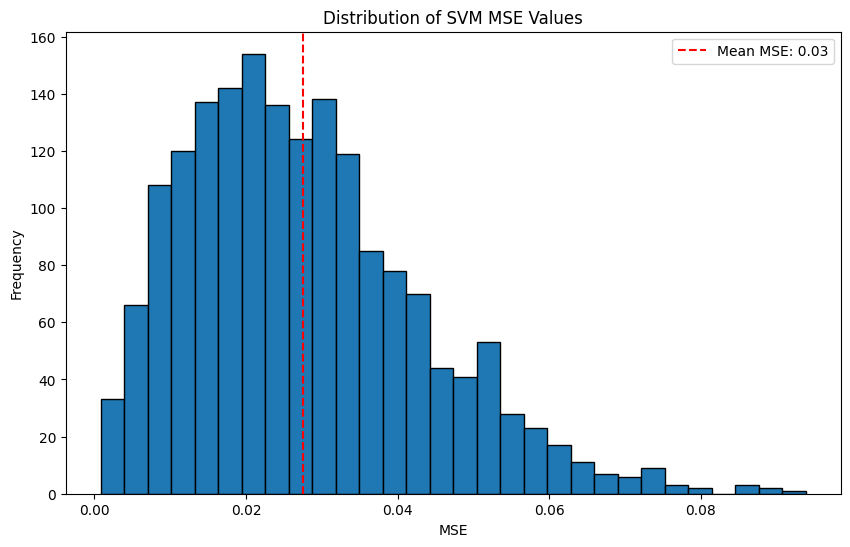

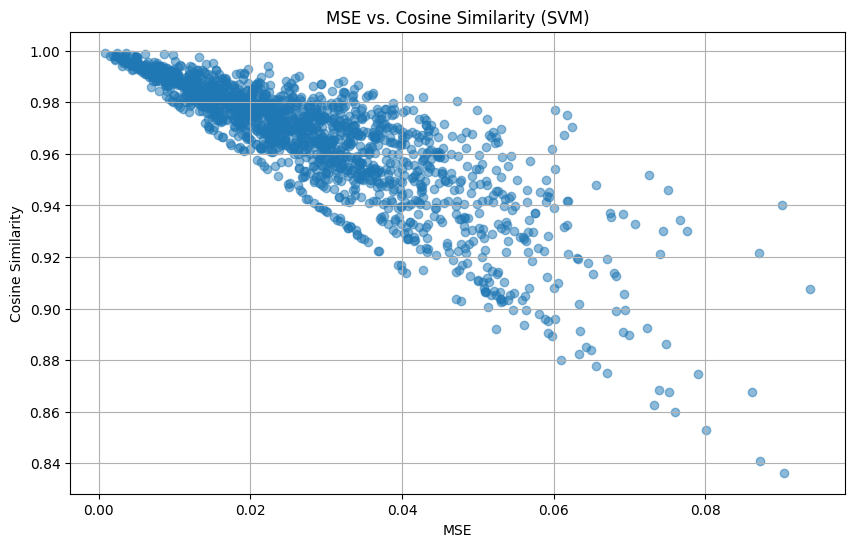

In [7]:
# Additional: MSE distribution across all patterns (for reference) fro SVM

svm_mse_values = [x['MSE'] for x in svm_metrics]

plt.figure(figsize=(10, 6))
plt.hist(svm_mse_values, bins=30, edgecolor='black')
plt.axvline(np.mean(svm_mse_values), color='red', linestyle='--', label=f'Mean MSE: {np.mean(svm_mse_values):.2f}')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('Distribution of SVM MSE Values')
plt.legend()
plt.show()

cosine_sim = [x['Cosine Similarity'] for x in svm_metrics]

plt.figure(figsize=(10, 6))
plt.scatter(svm_mse_values, cosine_sim, alpha=0.5)
plt.xlabel('MSE')
plt.ylabel('Cosine Similarity')
plt.title('MSE vs. Cosine Similarity (SVM)')
plt.grid(True)
plt.show()

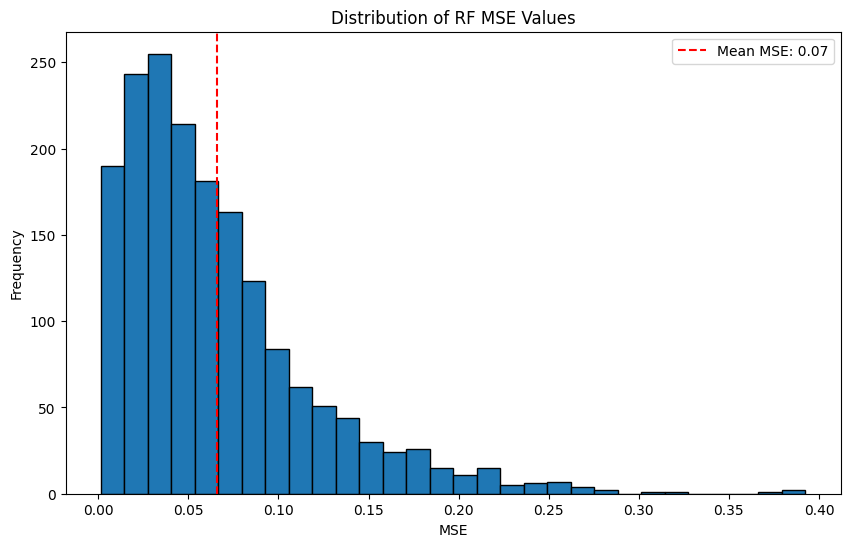

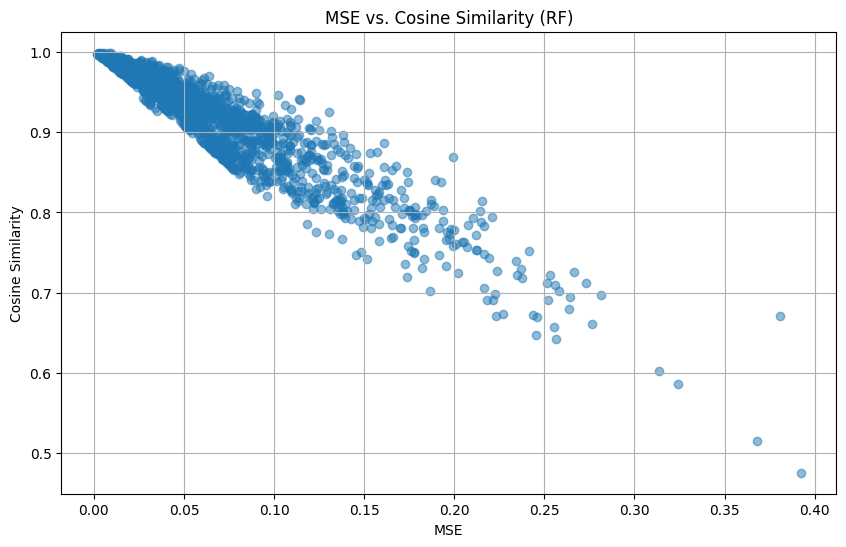

In [8]:
# Additional: MSE distribution across all patterns (for reference) fro Random Forest
rf_mse_values = [x['MSE'] for x in rf_metrics]

plt.figure(figsize=(10, 6))
plt.hist(rf_mse_values, bins=30, edgecolor='black')
plt.axvline(np.mean(rf_mse_values), color='red', linestyle='--', label=f'Mean MSE: {np.mean(rf_mse_values):.2f}')
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.title('Distribution of RF MSE Values')
plt.legend()
plt.show()

cosine_sim = [x['Cosine Similarity'] for x in rf_metrics]
plt.figure(figsize=(10, 6))
plt.scatter(rf_mse_values, cosine_sim, alpha=0.5)
plt.xlabel('MSE')
plt.ylabel('Cosine Similarity')
plt.title('MSE vs. Cosine Similarity (RF)')
plt.grid(True)
plt.show()
